In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from tensorflow.keras import layers
import time

from IPython import display

# Load & Normalize Data (-1 to 1)

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Normalise Data
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

BATCH_SIZE = 128

# Prepare Datasets

In [3]:
classes = {}

for i in range(10):
    classes[f"df_{i}"] = X_train[:8000][y_train[:8000] == i]

In [4]:
for i in range(10):
    num = len(classes[f"df_{i}"])
    print(i, num, np.round(num/8000*100, 2))


0 795 9.94
1 906 11.32
2 788 9.85
3 811 10.14
4 799 9.99
5 702 8.77
6 798 9.98
7 853 10.66
8 753 9.41
9 795 9.94


In [5]:
datasets_train = {}
# train_dataset_0 = tf.data.Dataset.from_tensor_slices(classes["df_0"][:800]).shuffle(len(classes["df_0"][:800])).batch(BATCH_SIZE)
train_dataset_0 = tf.data.Dataset.from_tensor_slices(classes["df_0"]).shuffle(len(classes["df_0"])).batch(BATCH_SIZE)
train_dataset_1 = tf.data.Dataset.from_tensor_slices(classes["df_1"]).shuffle(len(classes["df_1"])).batch(BATCH_SIZE)
train_dataset_2 = tf.data.Dataset.from_tensor_slices(classes["df_2"]).shuffle(len(classes["df_2"])).batch(BATCH_SIZE)
train_dataset_3 = tf.data.Dataset.from_tensor_slices(classes["df_3"]).shuffle(len(classes["df_3"])).batch(BATCH_SIZE)
train_dataset_4 = tf.data.Dataset.from_tensor_slices(classes["df_4"]).shuffle(len(classes["df_4"])).batch(BATCH_SIZE)
train_dataset_5 = tf.data.Dataset.from_tensor_slices(classes["df_5"]).shuffle(len(classes["df_5"])).batch(BATCH_SIZE)
train_dataset_6 = tf.data.Dataset.from_tensor_slices(classes["df_6"]).shuffle(len(classes["df_6"])).batch(BATCH_SIZE)
train_dataset_7 = tf.data.Dataset.from_tensor_slices(classes["df_7"]).shuffle(len(classes["df_7"])).batch(BATCH_SIZE)
train_dataset_8 = tf.data.Dataset.from_tensor_slices(classes["df_8"]).shuffle(len(classes["df_8"])).batch(BATCH_SIZE)
train_dataset_9 = tf.data.Dataset.from_tensor_slices(classes["df_9"]).shuffle(len(classes["df_9"])).batch(BATCH_SIZE)
datasets_train[0] = train_dataset_0
datasets_train[1] = train_dataset_1
datasets_train[2] = train_dataset_2
datasets_train[3] = train_dataset_3
datasets_train[4] = train_dataset_4
datasets_train[5] = train_dataset_5
datasets_train[6] = train_dataset_6
datasets_train[7] = train_dataset_7
datasets_train[8] = train_dataset_8
datasets_train[9] = train_dataset_9


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-26 19:14:48.599516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-26 19:14:48.600192: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Create GENERATOR

In [6]:
from tensorflow.keras import layers


def create_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None, 7, 7, 256)  # None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

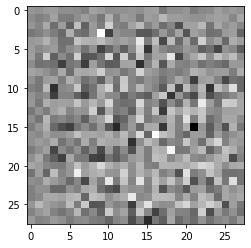

In [7]:
generator = create_generator_model()


noise = tf.random.normal([1,100])
img1 = generator(noise, training=False)

plt.imshow(img1[0, :, :, 0], cmap="gray")

# Create DISCRIMINATOR

In [8]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))  

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [9]:
discriminator = make_discriminator_model()

In [10]:
discriminator = make_discriminator_model()
generator = create_generator_model()
# print(generator.summary())
print(discriminator.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

# Loss Functions

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [12]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#0.0001

# Checkpoints

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [14]:
noise_dim = 100


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([BATCH_SIZE, noise_dim])


# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images, generator, discriminator, epoch):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss, d_real_loss, d_fake_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss, d_real_loss, d_fake_loss, gen_loss, generated_images


In [15]:
def train(dataset, dataclass, epochs, generator, discriminator, save_images_dict):

  for epoch in range(epochs):
    start = time.time()

    # acc = 0
    for image_batch in dataset:
      disc_loss, d_real_loss, d_fake_loss, gen_loss, gen_images = train_step(image_batch, generator, discriminator, epoch)
      save_images_dict[epoch] = gen_images

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             dataclass)

    # Save the model every 15 epochs
    # if (epoch + 1) % 15 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # print("Acc D:   ", acc/(len(dataset)))
    d_loss_plot.append(disc_loss)
    d_real_loss_plot.append(d_real_loss)
    d_fake_loss_plot.append(d_fake_loss)
    g_loss_plot.append(gen_loss)
    # acc_plot.append(disc_loss*0.5)

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           dataclass)
  # return gen_loss_dict, dis_loss_dict

# Create Images and save them

In [16]:
import os

def generate_and_save_images(model, epoch, test_input, dataclass):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  

  fig = plt.figure(figsize=(4, 4))
  for i in range(16):
    # pred = np.asarray(predictions[i, :, :, 0] * 127.5 + 127.5)
    #curr_IS = calculate_inception_score(pred)
    # gen.append(pred)
    
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  # Create directory to save generated images if not existent
  p = path+'{}'.format(dataclass)
  if not os.path.exists(p):
    os.makedirs(p)
  plt.savefig(p + '/image_epoch_{:04d}.png'.format(epoch))
  plt.show()


# Train GAN Models

In [17]:
from sklearn.metrics import accuracy_score

# Function to evaluate generated images
def evaluate_images_w_svm(imgs_dict, digit, epochs):
      G_arr = np.empty(shape=(epochs, 128, 28, 28, 1))
      for i in range(epochs):
            G_arr[i] = np.asarray(imgs_dict[i])

      preds = []
      plt.figure(figsize=(16,10))
      for i in range(epochs):
            predictions = svm_model.predict(G_arr[i].reshape(128,784))
            # classification_report(np.full(shape=256, fill_value=2), predictions)
            acc = accuracy_score(np.full(shape=128, fill_value=int(digit[-1])), predictions)
            preds.append(acc)
      # Save accuracies to dataframe and save it locally
      save_accuracy(preds, digit)
      plt.xlabel("Epoch", fontsize=14)
      plt.ylabel("Accuracy", fontsize=14)
      plt.title("Accuracy on Generated Images per Epoch", fontsize=16)
      plt.plot(preds)
      plt.tight_layout()
      plt.savefig(path + f"{digit}/accuracy_{digit}.svg", dpi=800, format="svg")
      plt.show()

In [18]:
# Function to save accuracies per epoch to csv file

def save_accuracy(accuracies_list, dataclass):
  # Create directory to save accuracies if not existent
  if not os.path.exists(path):
    os.makedirs(path)
  df = pd.DataFrame(accuracies_list)
  df.to_csv(path + f"{dataclass}/accuracy_{dataclass}.csv")

In [19]:
def plot_loss(title, d_loss, g_loss, d_loss_real=None, d_loss_fake=None):
  plt.figure(figsize=(16,10))
  plt.plot(g_loss_plot, c="green")

  if (d_loss_real and d_loss_fake):
    # plt.plot(d_loss, "--", c="orange")
    plt.plot(d_loss_real, c="blue")
    plt.plot(d_loss_fake, c="orange")
    plt.fill_between(np.arange(len(d_loss)),d_loss_real, d_loss_fake, alpha=0.4)
    plt.legend(["Generator","Discriminator (Real Images)","Discriminator (Fake Images)"], fontsize=14)
  else:
    plt.plot(d_loss)
    plt.legend(["Generator","Discriminator (Total)"], fontsize=14)

  if len(title) > 1:
    plt.title(f"{title[1]}: Discriminator and Generator Loss (Pre-trained on {title[0]})", fontsize=16)
  else:
    plt.title(f"{title}: Discriminator and Generator Loss", fontsize=16)
    
  plt.ylabel("Loss", fontsize=14)
  plt.xlabel("Epoch", fontsize=14)
  plt.tight_layout()
  plt.savefig(path + f"{title}/loss_plot_{title}.svg", dpi=800, format="svg")
  plt.show()

In [20]:
# Function to save accuracies per epoch to csv file

def save_losses(loss_lists, dataclass):
  # Create directory to save accuracies if not existent
  if not os.path.exists(path):
    os.makedirs(path)
  df = pd.DataFrame({"gen_loss":loss_lists[0],"d_loss_real":loss_lists[1],"d_loss_fake":loss_lists[2]})
  #print(df.head())
  df.to_csv(path + f"{dataclass}/loss_{dataclass}.csv")

# Dict to save dicts with generated images per epoch
GAN_0 = {}

generator_0 = create_generator_model()
discriminator_0 = make_discriminator_model()

gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

train(train_dataset_0, 0, 500, generator=generator_0, discriminator=discriminator_0, save_images_dict=GAN_0)
save_losses(loss_lists=[[x.numpy() for x in g_loss_plot],[x.numpy() for x in d_real_loss_plot],[x.numpy() for x in d_fake_loss_plot]], dataclass="0")
plot_loss("0", d_loss_plot, g_loss_plot, d_real_loss_plot, d_fake_loss_plot)

generator_01 = tf.keras.models.clone_model(generator_0)
generator_01.build((None, 100)) # replace 10 with number of variables in input layer
generator_01.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
generator_01.set_weights(generator_0.get_weights())

discriminator_01 = tf.keras.models.clone_model(discriminator_0)
discriminator_01.build((None, [28, 28, 1])) # replace 10 with number of variables in input layer
discriminator_01.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
discriminator_01.set_weights(discriminator_0.get_weights())


gen_loss_dict = {}
dis_loss_dict = {}
d_loss_plot = []
d_real_loss_plot = []
d_fake_loss_plot = []
g_loss_plot = []

GAN_01 = {}
train(train_dataset_1, 500, generator=generator_01, discriminator=discriminator_01, save_images_dict=GAN_01)
save_losses(loss_lists=[[x.numpy() for x in g_loss_plot],[x.numpy() for x in d_real_loss_plot],[x.numpy() for x in d_fake_loss_plot]], dataclass="01")

# Loss plots
plot_loss("01", d_loss_plot, g_loss_plot, d_real_loss_plot, d_fake_loss_plot)

# GANs: Training Loops

## Train SVM Classifier

In [21]:
### Hyperparameter Tuning ###

from sklearn.model_selection import GridSearchCV
from sklearn import svm, metrics

#nsamples, nx, ny = np.array(X_train[:8000]).shape
#train_data_svm_x = np.array(X_train[:8000]).reshape((nsamples,nx*ny))


# defining parameter range
param_grid = {'C': [0,1, 4, 8, 32], 'gamma': [1,0.1,0.01,0.001,0.0001],'kernel': ['rbf','poly']}
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2)
 
# fitting the model for grid search
#grid.fit(np.reshape(X_train[:8000], (8000,784)), y_train[:8000])
grid.fit(np.reshape(X_train, (60000,784)), y_train)

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ...........................C=0, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=0, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=0, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=0, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=0, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ..........................C=0, gamma=1, kernel=poly; total time=   0.1s
[CV] END ..........................C=0, gamma=1, kernel=poly; total time=   0.1s
[CV] END ..........................C=0, gamma=1, kernel=poly; total time=   0.1s
[CV] END ..........................C=0, gamma=1, kernel=poly; total time=   0.1s
[CV] END ..........................C=0, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0, gamma=0.1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0, gamma=0.

KeyboardInterrupt: 

In [22]:
import collections

counter = collections.Counter(y_train[:8000])
for i in range(10):
  num = counter[i]
  perc = np.round(num/8000*100, 2)
  print(i, num, perc)

0 795 9.94
1 906 11.32
2 788 9.85
3 811 10.14
4 799 9.99
5 702 8.77
6 798 9.98
7 853 10.66
8 753 9.41
9 795 9.94


In [23]:
counter = collections.Counter(y_test[:2400])
sum_perc = 0
sum_num = 0
for i in range(10):
  num = counter[i]
  perc = np.round(num/2400*100, 2)
  print(i, num, perc)


0 209 8.71
1 279 11.62
2 260 10.83
3 246 10.25
4 264 11.0
5 214 8.92
6 214 8.92
7 249 10.38
8 235 9.79
9 230 9.58


In [21]:
# SVM classifier
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


svm_model = svm.SVC(kernel="rbf", C=4, gamma=0.01)  # C and gamma based on hyperparameter tuning results (C:4, gamma:0.01, kernel:"rbf")
svm_model.fit(np.reshape(X_train[:8000], (8000,784)), y_train[:8000])
#svm_model.fit(np.reshape(X_train, (60000,784)), y_train)

SVC(C=4, gamma=0.01)

In [22]:
predictions = svm_model.predict(X_test[:2400].reshape(2400,784))
classification_score = classification_report(y_test[:2400], predictions)

print(classification_score)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       209
           1       0.98      0.99      0.98       279
           2       0.93      0.95      0.94       260
           3       0.94      0.96      0.95       246
           4       0.96      0.97      0.96       264
           5       0.96      0.93      0.95       214
           6       0.95      0.94      0.94       214
           7       0.95      0.92      0.93       249
           8       0.94      0.94      0.94       235
           9       0.95      0.92      0.93       230

    accuracy                           0.95      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.95      0.95      0.95      2400



In [23]:
accuracy_score(y_test[:2400], predictions)

0.9491666666666667

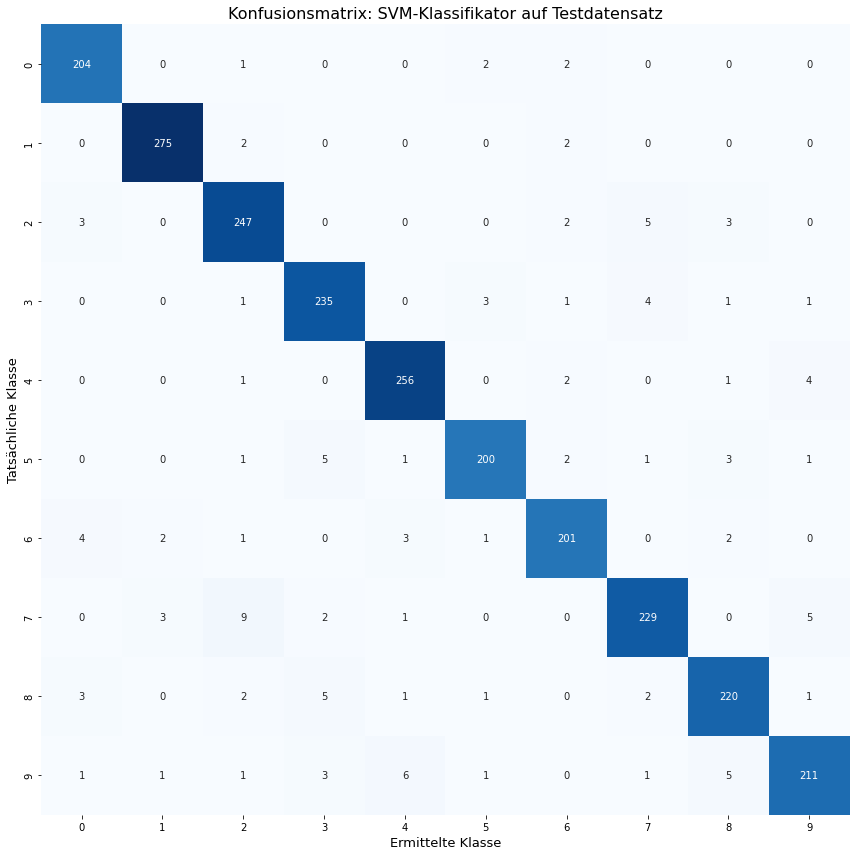

In [78]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test[:2400], predictions), annot=True, cbar=False, cmap="Blues", fmt='.0f')#, linewidths=0.5, linecolor="gray")
plt.xlabel('Ermittelte Klasse', fontsize=13)
plt.ylabel('Tatsächliche Klasse', fontsize=13)
plt.title("Konfusionsmatrix: SVM-Klassifikator auf Testdatensatz", fontsize=16)
plt.tight_layout()
#plt.savefig("generated/plots/confusion_matrix_test_set.svg")
plt.show()

## Training GANs

### Generating Digits 0-9

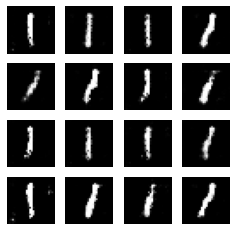

Time for epoch 43 is 1.3335578441619873 sec


KeyboardInterrupt: 

In [555]:
# GAN Training Loop
pd.options.mode.chained_assignment = None  # default='warn'

post_epochs = 300

imgs_dicts = {}


for i in range(10):
  print(f"** TRAINING  {i} **")
  gen_loss_dict = {}
  dis_loss_dict = {}
  d_loss_plot = []
  d_real_loss_plot = []
  d_fake_loss_plot = []
  g_loss_plot = []

  for pre_epochs in [100,200,300]:
    path = f"generated/images_{pre_epochs}pre_{post_epochs}post_test/"
    
    gen_loss_dict = {}
    dis_loss_dict = {}
    d_loss_plot = []
    d_real_loss_plot = []
    d_fake_loss_plot = []
    g_loss_plot = []

    # Dict to save dicts with generated images per epoche
    imgs_dicts[str(i)] = {}
    generator = create_generator_model()
    discriminator = make_discriminator_model()
    train(datasets_train[i], str(i), pre_epochs, generator=generator, discriminator=discriminator, save_images_dict=imgs_dicts[str(i)])
    save_losses(loss_lists=[[x.numpy() for x in g_loss_plot],[x.numpy() for x in d_real_loss_plot],[x.numpy() for x in d_fake_loss_plot]], dataclass=i)
    plot_loss(str(i), d_loss_plot, g_loss_plot)#, d_real_loss_plot, d_fake_loss_plot)

    # Evaluate generated images using SVM classifier
    evaluate_images_w_svm(imgs_dicts[str(i)], str(i), pre_epochs)

    for j in range(10):
      if i != j:
        print(f"** TRAINING  {i}{j} **")
        imgs_dicts[f"{i}{j}"] = {}
        generator_cpy = tf.keras.models.clone_model(generator)
        generator_cpy.build((None, 100))
        generator_cpy.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
        generator_cpy.set_weights(generator.get_weights())
        discriminator_cpy = tf.keras.models.clone_model(discriminator)
        discriminator_cpy.build((None, [28, 28, 1]))
        discriminator_cpy.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
        discriminator_cpy.set_weights(discriminator.get_weights())

        gen_loss_dict = {}
        dis_loss_dict = {}
        d_loss_plot = []
        d_real_loss_plot = []
        d_fake_loss_plot = []
        g_loss_plot = []

        train(datasets_train[j], f"{i}{j}", post_epochs, generator=generator_cpy, discriminator=discriminator_cpy, save_images_dict=imgs_dicts[f"{i}{j}"])
        save_losses(loss_lists=[[x.numpy() for x in g_loss_plot],[x.numpy() for x in d_real_loss_plot],[x.numpy() for x in d_fake_loss_plot]], dataclass=f"{i}{j}")
        plot_loss(f"{i}{j}", d_loss_plot, g_loss_plot)#, d_real_loss_plot, d_fake_loss_plot)

        # Evaluate generated images using SVM classifier
        evaluate_images_w_svm(imgs_dicts[f"{i}{j}"], f"{i}{j}", post_epochs)
      else:
        print(f"-- NOT TRAINING  {i}{j} --")


# Repetitive Training (Test how stable results are)

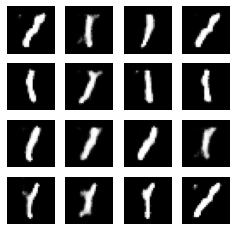

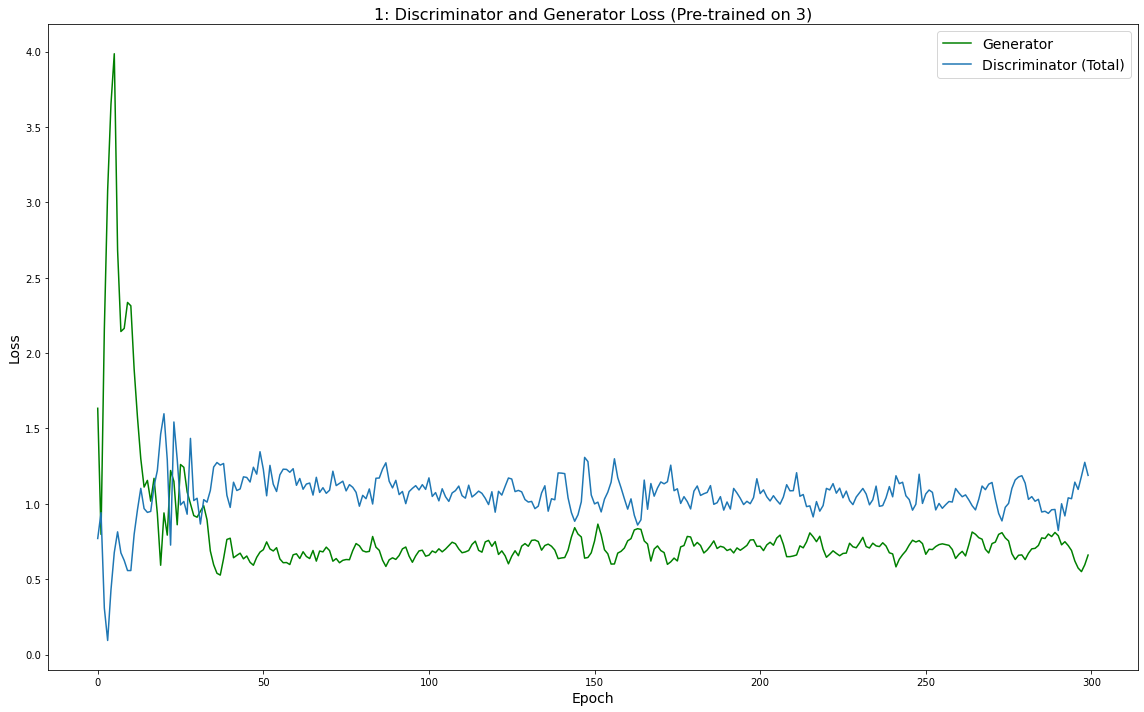

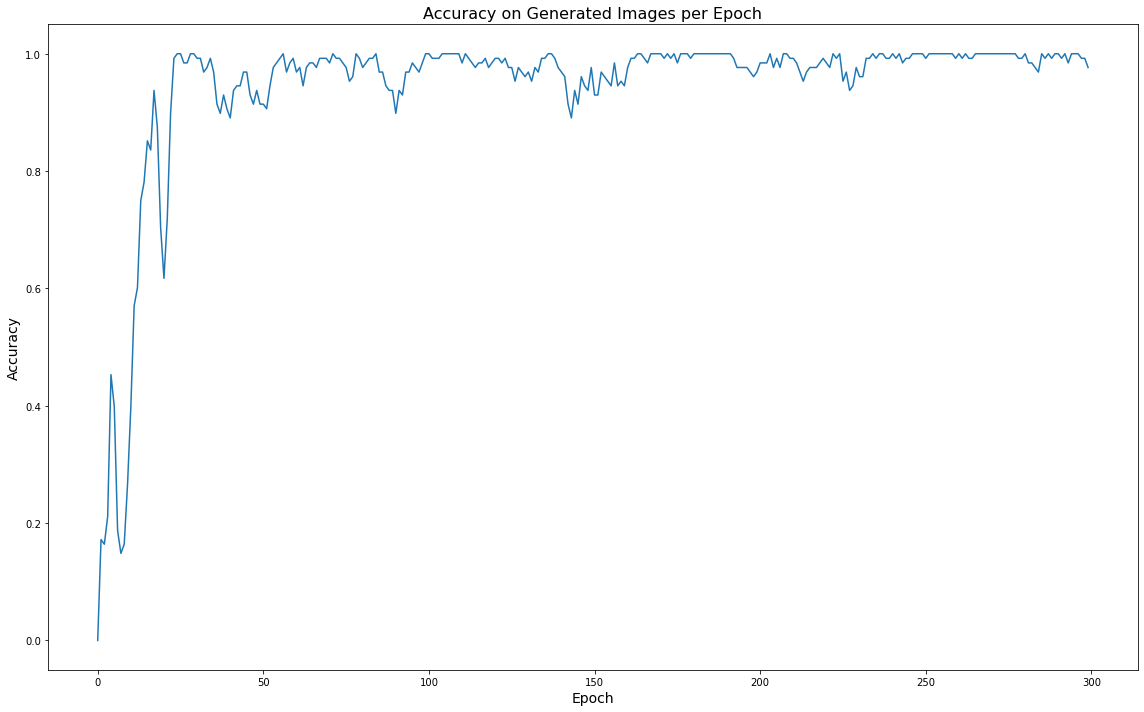

In [25]:
# GAN Training Loop
pd.options.mode.chained_assignment = None  # default='warn'

post_epochs = 300

for j in range(5):

  imgs_dicts = {}

  for i in [
            (8,(3,8)),(9,(4,9)),(9,(7,9)), (8,(5,8)), (8,(2,8)),
            (3,(1,3)), (7,(1,7)), (1,(0,1)), (1,(7,1)), (1,(3,1))
            ]:
    print(f"** TRAINING  {i[0]} **")
    gen_loss_dict = {}
    dis_loss_dict = {}
    d_loss_plot = []
    d_real_loss_plot = []
    d_fake_loss_plot = []
    g_loss_plot = []

    for pre_epochs in [300]:
      path = f"generated/is_stable_{j}/images_{pre_epochs}pre_{post_epochs}post_test/"
      
      gen_loss_dict = {}
      dis_loss_dict = {}
      d_loss_plot = []
      d_real_loss_plot = []
      d_fake_loss_plot = []
      g_loss_plot = []

      # Dict to save dicts with generated images per epoche
      imgs_dicts[str(i[0])] = {}
      generator = create_generator_model()
      discriminator = make_discriminator_model()
      train(datasets_train[i[0]], str(i[0]), pre_epochs, generator=generator, discriminator=discriminator, save_images_dict=imgs_dicts[str(i[0])])
      save_losses(loss_lists=[[x.numpy() for x in g_loss_plot],[x.numpy() for x in d_real_loss_plot],[x.numpy() for x in d_fake_loss_plot]], dataclass=i[0])
      plot_loss(str(i[0]), d_loss_plot, g_loss_plot)#, d_real_loss_plot, d_fake_loss_plot)
      # Evaluate generated images using SVM classifier
      evaluate_images_w_svm(imgs_dicts[str(i[0])], str(i[0]), pre_epochs)


      print(f"** PRE-TRAINING  {i[1][0]} **")

      gen_loss_dict = {}
      dis_loss_dict = {}
      d_loss_plot = []
      d_real_loss_plot = []
      d_fake_loss_plot = []
      g_loss_plot = []
      # Dict to save dicts with generated images per epoche
      imgs_dicts[str(i[1][0])] = {}
      generator = create_generator_model()
      discriminator = make_discriminator_model()
      train(datasets_train[i[1][0]], str(i[1][0]), pre_epochs, generator=generator, discriminator=discriminator, save_images_dict=imgs_dicts[str(i[1][0])])
      save_losses(loss_lists=[[x.numpy() for x in g_loss_plot],[x.numpy() for x in d_real_loss_plot],[x.numpy() for x in d_fake_loss_plot]], dataclass=i[1][0])
      plot_loss(str(i[1][0]), d_loss_plot, g_loss_plot)#, d_real_loss_plot, d_fake_loss_plot)
      # Evaluate generated images using SVM classifier
      evaluate_images_w_svm(imgs_dicts[str(i[1][0])], str(i[1][0]), pre_epochs)



      print(f"** TRAINING  {i[1][0]}{i[1][1]} **")
      imgs_dicts[f"{i[1][0]}{i[1][1]}"] = {}
      generator_cpy = tf.keras.models.clone_model(generator)
      generator_cpy.build((None, 100))
      generator_cpy.compile(optimizer=generator_optimizer, loss='categorical_crossentropy')
      generator_cpy.set_weights(generator.get_weights())
      discriminator_cpy = tf.keras.models.clone_model(discriminator)
      discriminator_cpy.build((None, [28, 28, 1]))
      discriminator_cpy.compile(optimizer=discriminator_optimizer, loss='categorical_crossentropy')
      discriminator_cpy.set_weights(discriminator.get_weights())

      gen_loss_dict = {}
      dis_loss_dict = {}
      d_loss_plot = []
      d_real_loss_plot = []
      d_fake_loss_plot = []
      g_loss_plot = []

      train(datasets_train[i[1][1]], f"{i[1][0]}{i[1][1]}", post_epochs, generator=generator_cpy, discriminator=discriminator_cpy, save_images_dict=imgs_dicts[f"{i[1][0]}{i[1][1]}"])
      save_losses(loss_lists=[[x.numpy() for x in g_loss_plot],[x.numpy() for x in d_real_loss_plot],[x.numpy() for x in d_fake_loss_plot]], dataclass=f"{i[1][0]}{i[1][1]}")
      plot_loss(f"{i[1][0]}{i[1][1]}", d_loss_plot, g_loss_plot)#, d_real_loss_plot, d_fake_loss_plot)

      # Evaluate generated images using SVM classifier
      evaluate_images_w_svm(imgs_dicts[f"{i[1][0]}{i[1][1]}"], f"{i[1][0]}{i[1][1]}", post_epochs)


    


